<a href="https://colab.research.google.com/github/m-shilpa/EVA4P2/blob/master/S2-MobileNets_and_Shufflenets/Setting_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Unzip the dataset

In [1]:
def unzip_files(filename = '/content/gdrive/My Drive/e4p2/dataset.zip'):
  
  from zipfile import ZipFile 
  import os

  # for i in os.listdir(File):
  #   filename = f'{File}/{i}'
  #   print(filename)
  # opening the zip file in READ mode 
  with ZipFile(filename, 'r') as zip_file: 
    
      # extracting all the files 
      print('Extracting all the files now...') 
      zip_file.extractall() 
      print('Done!')

In [2]:
unzip_files(filename='/content/gdrive/My Drive/e4p2/dataset_padded.zip')

In [4]:
!pip install torchsummary
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-7ia15ot2
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-7ia15ot2
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65436 sha256=d1a4ba82ebbbf6c70850ccebf42989e19cf2fe317dde76684a8d51dfda9dad79
  Stored in directory: /tmp/pip-ephem-wheel-cache-evhyqaxm/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.6
    Uninstalling albumentations-0.4.6:
      Successfully uninstalled albumentations-0.4.6


In [5]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Loading the dataset

In [6]:
# data loader
from torch.utils.data import Dataset
import random

def get_data(label_file='/content/gdrive/My Drive/e4p2/labels_num.txt',length=None):
    images = []
    target = []
    
    if length == None:
      labels = (open(label_file,'r')).readlines()
    else:
      labels = (open(label_file,'r')).readlines()[:length]
    for label in labels:
      a  = label.split(' ')
      images.append(f'/content/Dataset/{a[0]}')
      l = a[1].split('\n')
      target.append(l[0])         
    dataset =  list(zip(images,target))
    random.shuffle(dataset)
    train_split = 70
    train_len = len(dataset)*train_split//100
    train = dataset[:train_len]
    test = dataset[train_len:]
    return train,test

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.target = []
        self.input_images,self.target = zip(*data) 
           

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
  
        # print(self.target[idx],'---',idx,'----')
        input_image = np.asarray(Image.open(self.input_images[idx]))
        target = self.target[idx]
        
        if self.transform:
            input_image = self.transform(image=input_image)['image']
                    
        return input_image,target

def form_data(unzip=False,length =None, train_transform =None,test_transform =None):

  if unzip == True:
    unzip_files(filename='/content/gdrive/My Drive/e4p2/dataset_padded.zip')
  else:
    print('Files already downloaded')
  print('Forming the dataset')
  train, test = get_data(length=length)

  train_set = CustomDataset(train,transform=train_transform )
  test_set = CustomDataset(test,transform=test_transform )
  print('Done!')
  return train_set, test_set

In [7]:
# augmentations
import albumentations as A
import albumentations.pytorch as AP

mean = (0.53105756 , 0.58601165 , 0.61593276)

std = (0.28278487,  0.25762487 , 0.29407342)
	
train_transform = A.Compose(
    [ 
    #  A.ToGray( p=1.0),
     A.Resize(224, 224, interpolation=1, always_apply=True, p=1), 
     A.Cutout(num_holes=4, max_h_size=16,max_w_size = 16,p=1,fill_value=0.5*255), 
     A.Normalize(mean=mean, std=std),
     AP.ToTensor()        
             ])
            
test_transform = A.Compose(
    [ 
     A.Resize(224, 224, interpolation=1, always_apply=True, p=1),
     AP.ToTensor()        
             ])



In [8]:
train_set,test_set = form_data(unzip=False, train_transform=train_transform, test_transform=test_transform )                                        

Files already downloaded
Forming the dataset
Done!


In [9]:
# %%file data_load.py

import torch
import torchvision



def load(train_set,test_set,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	
	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()


	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(train_set, **dataloader_args)
	testloader = torch.utils.data.DataLoader(test_set, **dataloader_args)


	return  trainloader, testloader

In [10]:
trainloader,testloader = load(train_set,test_set,batch_size=128)

# Display the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape: torch.Size([128, 3, 224, 224])
Flying_Birds Winged_Drones Flying_Birds Winged_Drones Large_QuadCopters


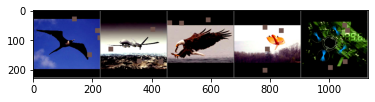

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

classes = ['Winged_Drones', 'Small_QuadCopters', 'Large_QuadCopters', 'Flying_Birds' ]
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def show_random_images(dataset, classes):

	# get some random training images
	dataiter = iter(dataset)
	images, labels = dataiter.next()

	img_list = range(5, 10)

	# show images
	print('shape:', images.shape)
	imshow(torchvision.utils.make_grid(images[img_list]))
	# print labels
  
	print(' '.join('%5s' % classes[int(labels[j])] for j in img_list))
 
show_random_images(trainloader, classes)

# Loading the model

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [13]:
from torchsummary import summary

In [14]:
model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True).to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


In [15]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [16]:
import torch.nn as nn
model.classifier[1] = nn.Linear(in_features=1280, out_features=4, bias=True).cuda()

In [17]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# Training and testing

In [18]:

class Train_test:
  
  def __init__(self):
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_acc_epoch_end = []
    self.train_loss_epoch_end = []

  def train_and_test(self,model, device, train_loader,test_loader, optimizer, criterion, epoch):
      
    
    self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end = self.train(model, device, train_loader, optimizer, criterion)
    self.test_losses,self.test_acc = self.test(model, device, criterion, test_loader)
    return self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end,self.test_losses,self.test_acc


  def train(self,model, device, train_loader, optimizer, criterion):

    import torch
    #Training & Testing Loops
    from tqdm import tqdm

    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      target = np.asarray(target)
      target = torch.from_numpy(target.astype('long'))
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      # loss = F.nll_loss(y_pred, target)
      loss = criterion(y_pred, target)
      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
    self.train_acc_epoch_end.append(self.train_acc[-1])
    self.train_loss_epoch_end.append(self.train_losses[-1])
    return self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end


  def test(self,model, device, criterion, test_loader):

      import torch
    #Training & Testing Loops
      from tqdm import tqdm

      model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
              target = np.asarray(target)
              target = torch.from_numpy(target.astype('long'))
              data, target = data.to(device), target.to(device)
              output = model(data)
              test_loss += criterion(output, target).item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()
              

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
      self.test_acc.append(100. * correct / len(test_loader.dataset))
      return self.test_losses,self.test_acc


In [19]:
# import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler

In [21]:
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")


EPOCHS = 2
l_rate = []
optimizer = optim.SGD(model.parameters(), lr=0.1,momentum=0.9) 
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1)
train_test = Train_test()
i=0
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
    l_rate.append(optimizer.param_groups[0]['lr'] )
    train_acc,train_acc_epoch_end,train_losses,train_loss_epoch_end,test_losses,test_acc = train_test.train_and_test(model, device, trainloader,testloader, optimizer, criterion, epoch)
    scheduler.step()

  0%|          | 0/117 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.1


Loss=0.9457905888557434 Batch_id=116 Accuracy=59.74: 100%|██████████| 117/117 [04:06<00:00,  2.11s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 2644/6401 (41.31%)

EPOCH: 2 LR: 0.1


Loss=0.736198365688324 Batch_id=116 Accuracy=64.79: 100%|██████████| 117/117 [04:06<00:00,  2.10s/it]



Test set: Average loss: 0.0178, Accuracy: 2590/6401 (40.46%)

